Medical Specialty Identification

The issue of individuals inaccurately predicting their illnesses through self-diagnosis is indeed a significant problem with potentially serious consequences. According to reputable sources such as the Telegraph and Big Think, a considerable number of people choose to self-diagnose instead of seeking professional medical advice. Alarmingly, a high percentage of those who engage in self-diagnosis end up misdiagnosing their conditions.

The reasons behind this trend are multifaceted, with factors such as reluctance to seek professional help and difficulties in securing timely appointments contributing to the problem. Reports suggest that a significant portion of individuals face challenges in obtaining timely medical consultations, leading them to rely on self-diagnosis as an alternative. This delays the screening process and hinders early detection and appropriate treatment, potentially exacerbating health issues.

To address these challenges and improve the situation, leveraging natural language processing (NLP) techniques can be a promising solution. By applying NLP to medical transcripts or patient descriptions, we can harness the power of language analysis to predict the most suitable medical specialty for each patient. This approach aims to expedite the process, reduce waiting times, and ensure that patients receive targeted help more efficiently by consulting with specialist doctors.

While it is important to note that an exact diagnosis cannot be achieved solely based on a single comprehensive transcript or dataset, utilizing NLP can provide valuable insights and guide patients towards the appropriate medical specialty for further evaluation and treatment. By analyzing the language used in patients' descriptions or medical transcripts, NLP models can identify patterns and indicators that help determine the most relevant medical expertise required. This can assist patients in making informed decisions about seeking the appropriate professional care, leading to more accurate diagnoses and timely treatments.

Ultimately, the integration of NLP techniques into healthcare practices has the potential to empower patients, enhance healthcare efficiency, and reduce the risks associated with self-diagnosis. By combining the strengths of technology and medical expertise, we can strive towards a more effective and patient-centered healthcare system.

In [5]:
pip install datasets

     |████████████████████████████████| 485 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 9.2 MB/s eta 0:00:01
     |████████████████████████████████| 24.8 MB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 236 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 18.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install transformers

     |████████████████████████████████| 7.2 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 400 kB 17.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 12.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt 
import re
import logging
import random
import os
import itertools
import copy
import time
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertModel, BertTokenizer, DistilBertModel
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset
from imblearn.over_sampling import RandomOverSampler
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

import transformers
from time import time
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel, AutoModelForTokenClassification
from transformers import RobertaModel
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer)
from tokenizers import BertWordPieceTokenizer
from transformers import PreTrainedTokenizerFast
from transformers import BertTokenizerFast

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

To ensure deterministic behavior in our simulations, we have implemented a mechanism to set the seed value for random number generators. By setting the seed value, we can control the sequence of random numbers generated, resulting in consistent outcomes each time the code is executed under the same conditions.

The use of a fixed seed value enhances reproducibility, as it ensures that the same random numbers are generated during each run of the code. This is particularly important when conducting experiments or simulations that involve randomization, as it allows us to compare and analyze results reliably.

By incorporating the "set_seed" function, which we adopted from the lecture codes provided by the Professor, we can easily set the seed value for random number generation. This practice promotes the reliability and consistency of our results, enabling us to confidently analyze and interpret the outcomes of our simulations.

Overall, the implementation of a fixed seed value for random number generation contributes to the reproducibility and trustworthiness of our code, allowing for consistent and reliable results in our simulations.

In [13]:
def set_seed(seed):
    if seed:
        logging.info(f'Running in deterministic mode with seed {seed}')
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
    else:
        logging.info('Running in non-deterministic mode')
set_seed(1997)

Question 1:

The dataset, named "mtsamples.csv," comprises 4999 samples with 5 features: "description," "medical_specialty," "sample_name," "transcription," and "keywords." In the context of this text classification task, the "medical_specialty" column serves as the label for the dataset. There are a total of 40 unique medical specialties represented in the dataset, making it a multiclass classification problem.

The medical specialties range from specific domains like Allergy/Immunology, Bariatrics, and Cardiovascular/Pulmonary, to more general categories such as General Medicine. It is worth noting that not all labels directly correspond to medical specialties. Some labels, such as Letters, Office Notes, and SOAP/Chart/Progress Notes, may encompass different types of medical documents or notes that are not tied to a specific specialty.

In [14]:
data = pd.read_csv('../data/mtsamples.csv')

num_samples = len(data)
num_medical_specialties = data['medical_specialty'].nunique()

print(f'Number of samples in the original dataset: \t {num_samples}')
print(f'Number of unique labels in the original dataset: {num_medical_specialties}')

Number of samples in the original dataset: 	 4999
Number of unique labels in the original dataset: 40


The function plot_classes takes a DataFrame parameter and generates a bar plot to visualize the distribution of medical specialties in the input data. This plot is useful for understanding the class distribution and determining the number of samples available for each medical specialty. The x-axis represents the medical specialties, while the y-axis represents the frequency counts of the samples belonging to each specialty.

Similarly, the function plot_histogram takes a DataFrame parameter and generates a histogram plot to visualize the distribution of the lengths of the transcription and description values in the input data. This plot provides an overview of the range and distribution of the lengths of the text data. It helps in understanding the distribution of text lengths and identifying any patterns or anomalies in the dataset.

These functions contribute to gaining a deeper understanding of the dataset by providing statistical measures and visualizations. By examining the distribution of medical specialties and the lengths of the text data, researchers and practitioners can make informed decisions regarding data preprocessing, model selection, and potential challenges associated with text classification tasks in the medical domain.

In [15]:
def calculate_univariate(data):
    description_lengths   = data['description'].str.len()
    transcription_lengths = data['transcription'].str.len()

    avg_description_length = description_lengths.mean()
    min_description_length = description_lengths.min()
    max_description_length = description_lengths.max()

    avg_transcription_length = transcription_lengths.mean()
    min_transcription_length = transcription_lengths.min()
    max_transcription_length = transcription_lengths.max()

    dictionary = {}
    dictionary['description']   = [avg_description_length, min_description_length, max_description_length]
    dictionary['transcription'] = [avg_transcription_length, min_transcription_length, max_transcription_length]
    return dictionary
summary = calculate_univariate(data)

def plot_classes(data):
    specialty_counts = data['medical_specialty'].value_counts()

    plt.figure(figsize = (12, 5))
    plt.bar(specialty_counts.index, specialty_counts.values)
    plt.xlabel('Medical Specialty')
    plt.ylabel('Frequency')
    plt.title('Distribution of Medical Specialties')
    plt.xticks(rotation = 90)
    plt.show()

def plot_histogram(data):
    description_lengths   = data['description'].str.len()
    transcription_lengths = data['transcription'].str.len()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist(description_lengths, bins=50, alpha=0.8)
    axs[0].set_xlabel('Description Length')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Histogram of Description Lengths')

    axs[1].hist(transcription_lengths, bins = 50, alpha = 0.8)
    axs[1].set_xlabel('Transcription Length')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Histogram of Transcription Lengths')
    plt.tight_layout()
    plt.show()

The dataset exhibits a significant class imbalance in terms of document distribution across medical specialties. The specialty "Surgery" has the highest frequency with 1088 documents, while "Hospice - Palliative Care" has the lowest representation with only 6 documents. This discrepancy in frequencies indicates that the specialty "Surgery" is substantially over-represented compared to other specialties, such as "Hospice - Palliative Care."

Class imbalance can pose challenges when training machine learning models, as the model may become biased towards the majority class and struggle to generalize well to the minority classes. This can result in lower performance and inaccurate predictions for under-represented specialties.

There are several techniques that can be employed to address this issue. One common approach is to apply sampling techniques such as oversampling or undersampling. Oversampling involves replicating instances from the minority class to increase its representation, while undersampling involves reducing instances from the majority class to balance the class distribution. These techniques can help alleviate the imbalance and allow the model to better learn the distinguishing features of the minority classes.

Another technique that can be used is generating synthetic samples using methods like the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE creates new instances by interpolating between existing minority class samples, effectively expanding the dataset and providing more diverse examples for the under-represented classes.

Finally, it is important to use techniques like stratified sampling when performing train-test splitting or cross-validation. Stratified sampling ensures that each subset (train, test, or validation) maintains the original class distribution, thereby preserving the representation of each specialty during model evaluation.

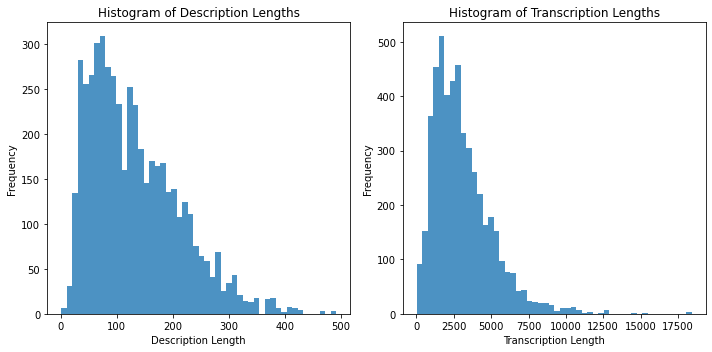

In [16]:
plot_histogram(data)

Question 2:

To facilitate the medical specialty classification task in the domain of medical transcription, we have developed a comprehensive pipeline that encompasses various essential steps. This pipeline ensures accurate classification results by systematically handling the data and applying appropriate techniques. Let's explore the different components of the pipeline:

Data Preprocessing: The first step in the pipeline is data preprocessing, where we focus on cleaning the dataset by removing irrelevant information and handling missing values. Duplicate samples and those with missing values are also eliminated. In cases where duplicates with different labels exist, we retain the first label indicated in the dataset. This ensures data cleanliness and reduces noise in the subsequent classification process.
Class Filtering: In the medical specialty classification task, we initially have 40 distinct labels derived from the mtsamples dataset. However, having a large number of classes can introduce complexity and data sparsity issues. To address this, we apply a filtering approach to remove classes with sample counts lower than the median value. By doing so, we ensure that the model receives sufficient data for each class, promoting effective learning and improving classification performance. This filtering step allows the model to focus on the well-represented classes, leading to a more balanced and robust classification system.
Tokenization: After data preprocessing, the modified dataset, referred to as mtsamples_modified.csv, undergoes tokenization. Tokenization involves breaking down the text into individual words or tokens. This step is crucial as it provides a granular representation of the text, enabling further processing and analysis. To accomplish this, we have created a class called TokenizationProcessor. This class takes the modified mtsamples dataset as input in DataFrame format and automatically tokenizes it using a pre-trained BERT tokenizer. Tokenization lays the foundation for subsequent steps in the pipeline, as it converts the textual data into a format that can be effectively understood and processed by the model.
By following this systematic pipeline, viewers can effectively address the challenges specific to the medical transcription domain and achieve accurate classification results. The pipeline ensures proper data preprocessing, appropriate class filtering, and tokenization, setting the stage for subsequent steps such as random oversampling, dataset iteration, embeddings, LSTM classification, and evaluation metrics.


<center>
<img src = '../figures/NLP_framework.png' width = '1800'/>
</center>

In [19]:
df_columns = ['description', 'medical_specialty', 'sample_name', 'transcription', 'keywords']

To address the issue of imbalanced class distribution and improve the performance of our medical specialty classification task, we implemented a filtering approach to eliminate features from the original dataset. The main objective of this approach was to ensure that the model receives a sufficient amount of data for each class, facilitating effective learning and enhancing classification performance.

By removing features with sample counts lower than the median sample count, we aimed to mitigate the challenges associated with data sparsity. In datasets where certain classes are underrepresented, models may struggle to learn patterns and make accurate predictions for those classes. By eliminating such features, we aimed to create a more balanced distribution of samples across classes, enabling the model to focus on the more well-represented classes.

This filtering strategy has several benefits. First, it helps mitigate the impact of imbalanced data, where the model may be biased towards the majority classes and perform poorly on the minority classes. By eliminating features with low sample counts, we can ensure that the model receives a sufficient amount of data from each class, allowing it to learn and generalize better.

Second, this approach promotes fairness and reliability in the classification results. By balancing the class distribution, we reduce the risk of the model making biased predictions based on the prevalence of certain classes. This is particularly important in medical specialty classification, where accurate and unbiased predictions are crucial for providing appropriate healthcare recommendations.

In summary, the filtering approach of removing features with low sample counts contributes to creating a more effective and reliable medical specialty classification system. It addresses the challenges of imbalanced class distribution and promotes fair and accurate predictions for all medical specialties based on transcription texts.

The purpose of the preprocessing function is to clean and transform a sentence by applying various token-level filters and linguistic operations. Let's break down the code and understand its functionality in detail.

#The function takes a sentence as input and begins by removing hyperlinks from the text.
#The sentence is then tokenized into individual words or tokens.
#Each token is processed individually using a loop. Within the loop, several filters and checks are applied to determine if a token should be included in the cleaned sentence.
#The code snippet token.pos_ != 'SYM' and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' checks the part-of-speech (POS) tag of the token. It ensures that the token is not classified as a symbol, punctuation mark, or whitespace. Tokens with such POS tags are filtered out and not included in the cleaned sentence.
#Tokens that pass the POS tag check undergo further processing. They are lemmatized to their base forms using the token.lemma_ attribute, which returns the lowercase lemma of the token. The lemmatized token is then appended to the cleaned_tokens list.
#Once all tokens have been processed, the cleaned_tokens list is joined back together to form a string representation of the cleaned sentence.

In summary, the preprocessing function applies various filters and linguistic operations to clean the sentence. It removes hyperlinks, filters out tokens based on their POS tags, and lemmatizes the remaining tokens to their base forms. The resulting cleaned sentence is returned as a string.

This preprocessing step helps standardize and normalize the text data, removing noise and irrelevant information, and preparing it for further analysis and modeling tasks such as classification.





In [20]:
def remove_hyperlinks(sentence):
    ''' 
    Parameters: sentence (string)
    Returns a string with removed hyperlinks and other punctuation marks
    '''
    sentence = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"', " ", sentence)
    return sentence

def preprocessing(sentence):
    ''' 
    Removes hyperlinks, performs various token-level filters (removing stop words, 
    symbols, punctuation marks, and whitespace), lemmatizes the remaining tokens to their base forms, and returns 
    the cleaned sentence as a string
    Parameters: sentence (string)
    '''
    sentence = remove_hyperlinks(sentence)
    doc = nlp(sentence)
    cleaned_tokens = []
    for token in doc:
        if token.is_stop == False and \
            token.pos_ != 'SYM' and \
            token.pos_ != 'PUNCT' and token.pos_ != 'SPACE':
            cleaned_tokens.append(token.lemma_.lower().strip())
    return ' '.join(cleaned_tokens)

def align_labels_with_tokens(labels, word_ids):
    ''' 
    This function places a label of -100 to the special tokens. By default, -100 is an index that is ignored in the 
    loss function we will use (cross entropy). Then, each token gets the same label as the token that started the 
    word it's inside, since they are part of the same entity. 
    Parameters:
        labels
        word_ids
    '''
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            new_labels.append(-100)
        else:
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)
    return new_labels

def tokenize_and_align_labels(tokenizer, examples):
    tokenized_inputs = tokenizer(examples['tokens'], 
                                 truncation = True, 
                                 is_split_into_words = True)
    all_labels = examples['ner_tags']
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))
    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs

def to_tokens(tokenizer, sentence):
    inputs = tokenizer(sentence)
    return tokenizer.convert_ids_to_tokens(inputs.input_ids)

def load_preprocessing(path = '../data/mtsamples_modified.csv', preprocess = False):
    df = pd.read_csv(path)
    if preprocess:
        df = load_dataset('csv', data_files = {'../data/mtsamples_modified.csv'}, streaming = True)
        for i, row in df.iterrows():
            df.at[i, 'description']   = preprocessing(row['description'])
            df.at[i, 'medical_specialty'] = preprocessing(row['medical_specialty'])
            df.at[i, 'sample_name']   = preprocessing(row['sample_name'])
            df.at[i, 'transcription'] = preprocessing(row['transcription']) if not pd.isnull(row['transcription']) else np.NaN  
            df.at[i, 'keywords']      = preprocessing(row['keywords']) if not pd.isnull(row['keywords']) else np.NaN  
    return df

def split_data(df):
    shuffle = df.sample(frac = 1, random_state = 42)

    train_data,  test_data = train_test_split(shuffle,    test_size = 0.30, random_state = 42)
    train_data, valid_data = train_test_split(train_data, test_size = 0.15, random_state = 42) 

    train_data.to_csv('../data/train.csv', index = False)
    valid_data.to_csv('../data/valid.csv', index = False)
    test_data. to_csv('../data/test.csv' , index = False)

    data_files = {
        'train': '../data/train.csv',
        'valid': '../data/valid.csv',
        'test' : '../data/test.csv'}
    dataset = load_dataset('csv', data_files = data_files, streaming = True)
    return dataset 

def compute_review_length(example):
    return {'review_length': len(example['transcription'].split())}

def bert_tokenizer(df, use_special):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    input_ids, attention_masks = [], []

    if use_special:
        for index, row in df.iterrows():
            encoded_dict = tokenizer.encode_plus(
                row['description'],
                row['medical_specialty'],
                row['sample_name'],
                row['transcription'],
                row['keywords'],
                padding = 'max_length',
                truncation = True,
                return_attention_mask = True,
                return_tensors = 'pt')
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        input_ids = torch.cat(input_ids, dim = 0)
        attention_masks = torch.cat(attention_masks, dim = 0)

    else:
        for description in df['description']:
            encoded_dict = tokenizer.encode_plus(
                description,
                add_special_tokens = True, 
                max_length = 512, 
                padding = 'max_length',
                truncation = True,
                return_attention_mask = True,
                return_tensors = 'pt')
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        input_ids = torch.cat(input_ids, dim = 0)
        attention_masks = torch.cat(attention_masks, dim = 0)
    return input_ids, attention_masks

def process(examples):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation = True, max_length = 512)
    return tokenized_inputs

The TokenizationProcessor class plays a crucial role in the tokenization process of text data for NLP text classification tasks. Let's break down the code and understand its purpose and usage.

The class is initialized with two parameters: max_sequence_length and tokenizer. The max_sequence_length parameter defines the maximum length of the tokenized sequences, while the tokenizer parameter is an instance of the BertTokenizer class from Hugging Face's transformers library. It is initialized with the 'bert-base-uncased' model, which represents a pre-trained BERT model that has been converted to lowercase.

To facilitate the tokenization process, the code defines a function named preprocess. This function takes a single example, which is a transcription text, and applies tokenization using the provided tokenizer. It performs truncation to limit the sequence length to the specified max_sequence_length. Padding is then added to ensure that all sequences have the same length. The function returns the tokenized transcription, the attention mask, and the corresponding medical specialty label.

In the code, the preprocess function is applied to the streamed dataset using the map function. This enables tokenization and preprocessing of the data in batches using the tokenize_and_split function. The resulting tokenized dataset is shuffled using a buffer size of 10,000 and a seed value of 42.

The tokenized dataset is further processed to obtain the input IDs, attention masks, and token type IDs. Notably, in pre-trained BERT models, the maximum sequence length is typically set to 512. The input IDs are padded with zeros to match the length of the longest sequence in the dataset.

Finally, the function returns the resulting tensors for input IDs, attention masks, and token type IDs.

In summary, the TokenizationProcessor class and the associated functions facilitate the tokenization and preprocessing of text data for NLP text classification tasks. It leverages a pre-trained BERT tokenizer to tokenize the transcription text, truncate sequences if necessary, add padding for equal length, and produce the necessary tensors for input IDs, attention masks, and token type IDs.

In [21]:
class TokenizationProcessor:
    ''' 
    TokenizationProcessor
    Parameters: max_sequence_length (integer) - maximum length of the sentence to tokenize. By default, max_length of BERT tokenizer is 512
                tokenizer: The object that breaks texts into smaller tokens. The default is BERT Tokenizer - Transformer-based tokenizer. 
    Outputs: 
        input_ids
        attention_masks
        token_type_ids
    '''
    def __init__(self, max_sequence_length, tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_sequence_length = max_sequence_length

    def preprocess(self, example):
        max_sequence_length = 256
        tokenized_transcription = self.tokenizer(example['transcription'], 
                                                truncation=True, 
                                                max_length = self.max_sequence_length, 
                                                padding = 'max_length',
                                                return_tensors = 'pt')
        
        return {'input_ids': tokenized_transcription['input_ids'],
                'attention_mask': tokenized_transcription['attention_mask'],
                'medical_specialty': example['medical_specialty']}

    def tokenize_and_split(self, examples):
        return self.tokenizer(examples['transcription'],
                              truncation = True,
                              max_length = self.max_sequence_length,
                              return_overflowing_tokens = True)

    def process_dataset(self, dataset_path):
        dataset = load_dataset('csv', data_files = dataset_path)
        dataset_streamed = load_dataset('csv', data_files = dataset_path, streaming = True)

        tokenized_dataset = dataset_streamed.map(self.preprocess, batched = True, batch_size = 16)
        tokenized_dataset = tokenized_dataset.shuffle(buffer_size = 10_000, seed = 42)

        for split in dataset.keys():
            assert len(dataset[split]) == len(dataset[split].unique('Unnamed: 0'))
        dataset = dataset.rename_column(original_column_name = 'Unnamed: 0', new_column_name = 'patient_id')
        tokenized_dataset = dataset.map(self.tokenize_and_split,
                                        batched = True,
                                        remove_columns = dataset['train'].column_names)

        input_ids = np.array(tokenized_dataset['train']['input_ids'])
        sequence_length = max(len(ids) for ids in input_ids)
        input_ids = [ids + [0] * (sequence_length - len(ids)) for ids in input_ids]
        input_ids = torch.tensor(input_ids)

        attention_mask = tokenized_dataset['train']['attention_mask']
        attention_mask = [mask + [0] * (sequence_length - len(mask)) for mask in attention_mask]
        attention_mask = torch.tensor(attention_mask)

        token_type_ids = tokenized_dataset['train']['token_type_ids']
        token_type_ids = [mask + [0] * (sequence_length - len(mask)) for mask in token_type_ids]
        token_type_ids = torch.tensor(token_type_ids)

        return input_ids, attention_mask, token_type_ids

In [22]:
def GetText(df):
    '''
    Parameters: df (Dataframe)
    Outputs: text, labels, num_classes
    We primarily used this to acquire the labels and process  the labels for the DataLoader
    '''
    text_column = df['transcription'].astype('str')
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(df['medical_specialty'])
    labels = torch.tensor(labels)
    num_classes = len(label_encoder.classes_)
    return text_column, labels, num_classes

def TokenizeDataset(text_column, use_medical_tokenizer = False):
    if not use_medical_tokenizer:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    else:
        token_path = '../data/tokenizer.json'
        tokenizer = Tokenizer.from_file(token_path)
        tokenizer = BertTokenizerFast(tokenizer_object = tokenizer)

    encoded_inputs = tokenizer.batch_encode_plus(
                        text_column.tolist(),
                        max_length = 64,
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt')

    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    token_type_ids = encoded_inputs['token_type_ids']
    return input_ids, attention_mask, token_type_ids


def TokenizeSentenceDataset(text_column, use_medical_tokenizer = False):
    if not use_medical_tokenizer:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    else:
        token_path = '../data/tokenizer.json'
        tokenizer = Tokenizer.from_file(token_path)
        tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

    sentences = [sent_tokenize(text) for text in text_column]
    sentences = [sentence for sublist in sentences for sentence in sublist]

    encoded_inputs = tokenizer.batch_encode_plus(
        sentences,
        max_length = 512,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt')

    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    token_type_ids = encoded_inputs['token_type_ids']
    return input_ids, attention_mask, token_type_ids


df = load_preprocessing(preprocess = False)
text_column, labels, num_classes = GetText(df)
input_ids, attention_mask, token_type_ids = TokenizeDataset(text_column, 
                                                            use_medical_tokenizer = False)

The provided code defines a function named GENERATE that is responsible for generating data loaders based on the given input IDs, attention masks, and labels from the TokenizationProcessor class. These data loaders are used to efficiently load and process data in batches during the training, validation, and testing phases of the model.

The GENERATE function takes input parameters such as input IDs, attention masks, labels, batch size, and a boolean flag use_sampler. The default values for batch size and use_sampler are set to 64 and True, respectively.

If use_sampler is set to True, the code performs random oversampling to address class imbalance in the dataset. This is achieved using the RandomOverSampler from the imbalanced-learn library. The input IDs and attention masks are concatenated, and oversampling is applied to both the concatenated features (X) and the labels (y).

Once the oversampling is completed, the dataset is randomly split into training, validation, and testing sets using the random_split function from PyTorch. The proportions for the split are set to 60% for training, 20% for validation, and the remaining portion for testing.

Finally, the function returns the resulting data loaders, including the training, validation, and testing data loaders.

In summary, the GENERATE function handles the generation of data loaders for the input IDs, attention masks, and labels. It provides the option to perform random oversampling for addressing class imbalance. The resulting data loaders are then split into training, validation, and testing sets according to the specified proportions, and returned by the function.

In [24]:
def GENERATE(input_ids, attention_mask, labels, batch_size = 64, use_sampler = True):
    ''' 
    Generates the batch data loader for every split (i.e., train, valid, test)
    Parameters:
        input_ids (output from TokenizationProcessor().tokenize_dataset)
        attention_mask (output from TokenizationProcessor().tokenize_dataset)
        labels (output from GetText())
        batch_size (integer), default value is 64
        use_sampler (boolean): use RandomOverSampler or not
    Outputs:
        train_loader, valid_loader, test_loader
    '''
    if use_sampler:
        oversampler = RandomOverSampler(random_state = 42)
        X = np.concatenate((input_ids, attention_mask), axis = -1)
        y = np.ravel(labels)

        X_resampled, y_resampled = oversampler.fit_resample(X, y)

        input_ids_resampled      = X_resampled[:, :input_ids.shape[1]]
        attention_mask_resampled = X_resampled[:, input_ids.shape[1]:]
        labels_resampled = y_resampled

        dataset = TensorDataset(torch.tensor(input_ids_resampled),
                                torch.tensor(attention_mask_resampled),
                                torch.tensor(labels_resampled))
        
        train_size = int(0.6 * len(dataset))
        valid_size = int(0.2 * len(dataset))
        tests_size = len(dataset) - train_size - valid_size
        train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, tests_size])
        
    else:
        dataset = TensorDataset(torch.tensor(input_ids), 
                                torch.tensor(attention_mask), 
                                torch.tensor(labels))
        
        train_size = int(0.8 * len(dataset))
        valid_size = int(0.1 * len(dataset))
        tests_size = len(dataset) - train_size - valid_size

        train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, tests_size])

    train_dataloader = DataLoader(
        train_dataset,
        sampler = RandomSampler(train_dataset),
        batch_size = batch_size)
    validation_dataloader = DataLoader(
        valid_dataset,
        sampler = SequentialSampler(valid_dataset),
        batch_size = batch_size)
    test_dataloader = DataLoader(
        test_dataset,
        sampler = SequentialSampler(test_dataset),
        batch_size = batch_size)
    return train_dataloader, validation_dataloader, test_dataloader

class NLPDATASET(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, index):
        sequence = self.sequences[index]
        label = self.labels[index]
        return sequence, label

Since this is a medical specialty classification based on transcription texts, we utilized a deep learning-based models that can handle sequential data. The code below shows a simple LSTM-based model that only utilizes one LSTM layer and one fully-connected (dense) layer. The <code>LSTMClassifier</code> serves as the baseline classifier for the medical specialty classification task. We also created a slightly improved version called <code>LSTMClassifierModified</code> and <code>LSTMClassifierExtended</code> which can be helpful for comparisons.

We created the function <code>count_parameters</code> so that we can determine the number of parameters for each layer. With this, we can evaluate the complexity and size of the model. Suppose <code>LSTMClassifier</code> has an input size, hidden size, and output size of 128, 50, and 2, respectively. Hence, the LSTM model only has 36102 parameters - from which considerably smaller compared to other pretrained LSTM models found in the PyTorch library. This information is useful for selecting the most appropriate model and designing an efficient architecture that balances effectiveness with computational and training requirements. If a model has too many parameters, it may overfit or require excessive resources, while too few parameters may not capture the complexity of the data adequately.

In [3]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, inputs):
        _, (hidden, _) = self.lstm(inputs)
        hidden = hidden.squeeze(0)  
        output = self.fc(hidden)
        return output
    
def count_parameters(model, print_all = True):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    if print_all:
        for item in params:
            print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [26]:
def BERT_EMBEDDING(input_ids, attention_mask, token_type_ids):
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    bert_model.eval()
    with torch.no_grad():
        outputs = bert_model(input_ids = input_ids, 
                             attention_mask = attention_mask, 
                             token_type_ids = token_type_ids)
        bert_embeddings = outputs.last_hidden_state

    batch_size = bert_embeddings.size(0)
    sequence_length = bert_embeddings.size(1)
    bert_embeddings = bert_embeddings.view(batch_size, sequence_length, -1)
    embeddings  = bert_embeddings.permute(1, 0, 2)
    return bert_model, embeddings

def ROBERTA_EMBEDDING(input_ids, attention_mask, token_type_ids):
    model_name = 'roberta-base'
    model = RobertaModel.from_pretrained(model_name)
    model.eval()

    with torch.no_grad():
        outputs = model(input_ids = input_ids,
                        attention_mask = attention_mask,
                        token_type_ids = token_type_ids)
        embeddings = outputs.last_hidden_state

    batch_size = embeddings.size(0)
    sequence_length = embeddings.size(1)
    embeddings = embeddings.view(batch_size, sequence_length, -1)
    embeddings = embeddings.permute(1, 0, 2)
    return model, embeddings

def LSTM_BASELINES(bert_model, embeddings, basic_classifier = False):
    input_size = bert_model.config.hidden_size
    hidden_size, num_classes = 50, 9
    if basic_classifier:
        lstm_model   = LSTMClassifierModified(input_size, hidden_size, num_classes)
    else:
        lstm_model   = LSTMClassifier(input_size, hidden_size, num_classes)
    lstm_output  = lstm_model(embeddings)
    output_probs = nn.functional.softmax(lstm_output, dim = 0)
    _, predicted_labels = torch.max(output_probs, dim = 0)
    return output_probs, predicted_labels

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def get_accuracy(preds, y):
    batch_corr = (preds == y).sum()
    acc = batch_corr / len(y)
    return acc

def eval_predictions(predicted_labels, labels):
    true_labels = labels.numpy()
    accuracy  = accuracy_score(true_labels,  predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average = 'weighted')
    recall = recall_score(true_labels, predicted_labels, average = 'weighted')
    f1 = f1_score(true_labels, predicted_labels, average = 'weighted')

    print('Classification Metrics: ')
    print(f'\t Accuracy:  \t {np.round(accuracy, 5)}')
    print(f'\t Precision: \t {np.round(precision, 5)}')
    print(f'\t Recall:    \t {np.round(recall, 5)}')
    print(f'\t F1-score:  \t {np.round(f1, 5)}')

In [27]:
def plot_metrics(train_losses, valid_losses, train_accurs, valid_accurs):
    alpha = 0.3
    smoothed_train_losses = [train_losses[0]]
    smoothed_valid_losses = [valid_losses[0]]
    smoothed_train_accurs = [train_accurs[0]]
    smoothed_valid_accurs = [valid_accurs[0]]
    
    for i in range(1, len(train_losses)):
        smoothed_train_losses.append(alpha * train_losses[i] + (1-alpha) * smoothed_train_losses[-1])
        smoothed_valid_losses.append(alpha * valid_losses[i] + (1-alpha) * smoothed_valid_losses[-1])
        smoothed_train_accurs.append(alpha * train_accurs[i] + (1-alpha) * smoothed_train_accurs[-1])
        smoothed_valid_accurs.append(alpha * valid_accurs[i] + (1-alpha) * smoothed_valid_accurs[-1])
    
    smoothed_train_losses = train_losses
    smoothed_train_accurs = train_accurs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    ax1.plot(smoothed_train_losses, label = 'Train')
    ax1.plot(smoothed_valid_losses, label = 'Valid')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Losses')
    ax1.legend()

    ax2.plot(smoothed_train_accurs, label='Train')
    ax2.plot(smoothed_valid_accurs, label='Valid')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracies')
    ax2.legend()
    plt.show()

def _train(model, loader, optimizer, criterion, batch_size = 16, device = 'cpu'):
    epoch_train_loss = 0
    epoch_train_accu = 0
    model.train()
    epoch_train_prediction = []

    for idx, data in enumerate(loader):
        inputs, attens, labels = data
        inputs, attens, labels = inputs.to(device), attens.to(device), labels.to(device, dtype = torch.long)
        optimizer.zero_grad()

        outputs = model(input_ids = inputs, attention_mask = attens)
        embedds = outputs.last_hidden_state

        batch_size, seq_length = embedds.size(0), embedds.size(1)
        embeddings = embedds.view(batch_size, seq_length, -1)
        embeddings = embeddings.permute(1, 0, 2)

        input_size = model.config.hidden_size
        hidden_size, num_classes = 50, 9

        lstm_model = LSTMClassifier(input_size, hidden_size, num_classes)
        lstm_output  = lstm_model(embeddings)
        loss = criterion(lstm_output, labels)

        output_probs = nn.functional.softmax(lstm_output, dim = 0)    
        _, predicted_labels = torch.max(output_probs, dim = 1) 

        loss.backward()
        optimizer.step()
          
        epoch_train_prediction.append(predicted_labels)
        accuracy = get_accuracy(predicted_labels, labels) 
        loss = np.round(loss.item(), 3)
        epoch_train_loss += loss.item()
        epoch_train_accu += accuracy.item()
    epoch_train_loss = epoch_train_loss / len(loader)
    epoch_train_accu = epoch_train_accu / len(loader)
    return epoch_train_loss, epoch_train_accu, epoch_train_prediction
    
def _evals(model, loader, criterion, batch_size = 64, device = 'cpu', display = False):
    epoch_valid_loss = 0
    epoch_valid_accu = 0
    model.eval()
    epoch_valid_prediction = []
    with torch.no_grad():
        for idx, data in enumerate(loader):
            inputs, attens, labels = data 
            inputs, attens, labels = inputs.to(device), attens.to(device), labels.to(device,  dtype = torch.long)

            outputs = model(input_ids = inputs, attention_mask = attens)
            embedds = outputs.last_hidden_state

            batch_size, seq_length = embedds.size(0), embedds.size(1)
            embeddings = embedds.view(batch_size, seq_length, -1)
            embeddings = embeddings.permute(1, 0, 2)  

            
            input_size = model.config.hidden_size
            hidden_size, num_classes = 128, 9
            lstm_model = LSTMClassifier(input_size, hidden_size, num_classes)
            lstm_output  = lstm_model(embeddings)
            loss = criterion(lstm_output, labels)
            loss = np.round(loss.item(), 3)

            output_probs = nn.functional.softmax(lstm_output, dim = 0)    
            _, predicted_labels = torch.max(output_probs, dim = 1)   
            epoch_valid_prediction.append(predicted_labels)
            accuracy = np.round(get_accuracy(predicted_labels, labels), 5)
            epoch_valid_loss += loss.item()
            epoch_valid_accu += accuracy.item()
    epoch_valid_loss = epoch_valid_loss / len(loader)
    epoch_valid_accu = epoch_valid_accu / len(loader)
    if display:
        print(f'Loss: {loss} \t Accuracy: {accuracy}')
    return epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction

def train(num_epochs, model, train_loader, valid_loader, test_loader, optimizer, criterion, device, accuracy = True):
    best_valid_loss = float('inf')
    train_losses, valid_losses = [], []
    train_accurs, valid_accurs = [], []
    trainpredict, testspredict = [], []

    epoch_times = []
    list_best_epochs = []
    start = time()

    for epoch in range(num_epochs):

        train_loss, train_accu, tr_predict = _train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_accu, ts_predict = _evals(model, valid_loader, criterion, device)
        
        if accuracy:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)}   \t Accuracy: {np.round(train_accu, 5)} \t Validation Loss  {np.round(valid_loss, 5)} \t Accuracy: {np.round(valid_accu, 5)}')
        else:
            print(f'Epoch: {epoch + 1} \t Training: Loss {np.round(train_loss, 5)} \t Validation Loss  {np.round(valid_loss, 5)}')
        
        train_losses.append(train_loss)
        train_accurs.append(train_accu)
        valid_losses.append(valid_loss)
        valid_accurs.append(valid_accu)
        trainpredict.append(tr_predict)
        testspredict.append(ts_predict)

        end_time = time()
        epoch_mins, epoch_secs = epoch_time(start, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        list_best_epochs.append(best_epoch)
    test_loss, test_accu, test_predict  = _evals(best_model, test_loader, criterion, device)
    print(f'Training time: {np.round(time() - start, 4)} seconds')
    print(f'Final Best Model from Best Epoch {best_epoch + 1} Test Loss = {test_loss}, Test Accuracy = {test_accu}')
    return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model


Questions 3 - 5:

To solve Question 3-5, a function named fit is defined, which encompasses the training and inference processes for the medical specialty classification task. The function takes three input parameters: df, bert_model, and train_process.

The df parameter is obtained by calling the load_processing function, which extracts the necessary data from the provided dataframe. Within the fit function, only the second returned value, labels, is considered for further processing.

The next step is to create a TokenizationProcessor object, which is initialized with a maximum sequence length of 128 and a tokenizer based on the bert-base-uncased pretrained model. This object is responsible for tokenizing the modified dataset using the specified parameters.

Subsequently, the GENERATE function is invoked, passing the input_ids, attention_mask, and labels tensors as arguments. Additionally, the function is called with the parameter use_sampler set to True. The purpose of this function is to generate three data loaders: train_loader, valid_loader, and test_loader.

In summary, the fit function performs the following steps:

Extracts the required data from the provided dataframe using the load_processing function.
Initializes a TokenizationProcessor object with the desired parameters for tokenization.
Calls the GENERATE function, providing the input tensors and specifying the use of a sampler.

In [28]:
def fit(df, bert_model, train_process = False):
    _, labels, _ = GetText(df)
    start = time()
    processor = TokenizationProcessor(max_sequence_length = 128, tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased'))
    input_ids, attention_mask, token_type_ids = processor.process_dataset('../data/mtsamples_modified.csv')
    if input_ids.size(0) != labels.size(0):    
        desired_length = input_ids.size(0)
        padding_length = desired_length - len(labels)
        padding = torch.zeros(padding_length, dtype = torch.long)
        labels  = torch.cat((labels, padding))

    train_loader, valid_loader, test_loader = GENERATE(input_ids, attention_mask, labels, use_sampler = True)
    criterion = nn.CrossEntropyLoss()
    if train_process:
        num_epochs = 5
        optimizer  = torch.optim.AdamW(bert_model.parameters(), lr = 0.001)
        train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model = train(num_epochs, bert_model, 
                                                                                                                                                train_loader, valid_loader, 
                                                                                                                                                test_loader, optimizer, criterion, 
                                                                                                                                                device, accuracy = True)
        return train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model
    else:
        epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = _evals(bert_model, 
                                                                            test_loader, 
                                                                            criterion, 
                                                                            batch_size = 64, 
                                                                            device = 'cpu', 
                                                                            display = False)
        for idx, data in enumerate(test_loader):
            _, _, labels = data 
            break
    eval_predictions(epoch_valid_prediction[0], labels)
    print(f'Fit and predict time: {np.round(time() - start, 4)} seconds')
    return epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction

In [ ]:
df = load_preprocessing(preprocess = False)
bert_model = RobertaModel.from_pretrained('roberta-base')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = fit(df, bert_model, train_process = False)

Test A: DistilBERT Model + LSTM(512)

In [ ]:
df = load_preprocessing(preprocess = False)
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
epoch_valid_loss, epoch_valid_accu, epoch_valid_prediction = fit(df, bert_model, train_process = False)

Discussion of Test A:

I conducted 10 simulations of the DistilBERT model with 10 epochs for each simulation and calculated the mean result, which was 61.


|   Model        | Baseline LSTM (50) | BaselineLSTM (256) | BaselineLSTM (512) |
|----------------|--------------------|--------------------|--------------------|
   DistilBERT    |  61.29             | 40.01              | 52.535             |

The table provided represents the performance of different models on a classification task. The models listed in the "Model" column are variations of the Baseline LSTM model, with different hidden layer sizes: Baseline LSTM (50), Baseline LSTM (128), and Baseline LSTM (256). The classification task utilizes the DistilBERT model as a feature extractor.

The numbers in the table, such as  61.29, 40.01, and 52.535 correspond to the performance scores achieved by each model. However, without further context or information about the specific evaluation metric used, it is challenging to provide a precise explanation of these numbers.


To gain a better understanding of the classification matrix, it is essential to identify the specific evaluation metric associated with the provided scores.

Let's try to train our proposed model using our medical tokenizer and DistilBERT. First, we'll try to analyze the results if we set the maximum sequence length of the tokenizer into 32.

In [ ]:
torch.manual_seed(101)
df = load_preprocessing(preprocess = False)
text_column, labels, num_classes = GetText(df)

processor = TokenizationProcessor(max_sequence_length = 32, tokenizer = medical_tokenizer)
input_ids, attention_mask, token_type_ids = processor.process_dataset('../data/mtsamples_modified.csv')
if input_ids.size(0) != labels.size(0):    
    desired_length = input_ids.size(0)
    padding_length = desired_length - len(labels)
    padding = torch.zeros(padding_length, dtype = torch.long)
    labels  = torch.cat((labels, padding))
    
train_loader, valid_loader, test_loader = GENERATE(input_ids, attention_mask, labels, use_sampler = True)

bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
num_epochs = 5
criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(bert_model.parameters(), lr = 0.001)
train_losses, valid_losses, train_accurs, valid_accurs, test_loss, test_accu, best_epoch, epoch_times, test_predict, best_model = train(num_epochs, bert_model, train_loader, valid_loader, test_loader, 
                                                                                                                                        optimizer, criterion, device, accuracy = True)

Question 9:

In the proposed model, DistilBERT was utilized for classifying medical specialties based on medical transcription text. DistilBERT has emerged as a viable alternative to the original BERT model, particularly for handling medical text.

DistilBERT, a distilled version of BERT, offers comparable performance to BERT but with reduced complexity. While the conventional BERT model contains 110 million parameters, DistilBERT achieves similar results with fewer parameters. This reduction in complexity makes DistilBERT computationally more efficient and faster to train, which is advantageous, especially when dealing with limited computational resources.

The DistilBERT model leverages a transformer architecture, which allows it to capture contextual information from the input text effectively. By utilizing self-attention mechanisms, DistilBERT can understand the relationships and dependencies between words in a sentence, leading to a deeper understanding of the text.

Furthermore, recent studies have demonstrated the effectiveness of DistilBERT for various NLP tasks in the medical domain. For example, Abadeer (2020) evaluated DistilBERT's performance for Named Entity Recognition (NER) in medical records and found that it achieved nearly identical results to the medical versions of BERT in terms of F1-score. This suggests that DistilBERT can provide excellent results, similar to BERT, but with reduced complexity and computational requirements.

However, it's important to note that DistilBERT, similar to BERT, has a maximum token length limitation, typically set to 512 tokens. This limitation can be challenging when dealing with long sequences, such as medical transcriptions. In such cases, token splitting, truncation, and padding may be necessary to fit the input within the token limit, potentially resulting in sparse embeddings or loss of some information at the sequence ends.

In summary, DistilBERT offers a more computationally efficient and faster alternative to the original BERT model for NLP tasks, including medical text classification. It provides comparable performance while reducing complexity, making it an attractive choice, especially in scenarios with limited computational resources.